# Resume Shortlister Model Train:
---
## Importing Libraries:

In [131]:
import os, re, nltk, sys
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from langchain.document_loaders import PyMuPDFLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
import numpy as np, pandas as pd

from dotenv import load_dotenv

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
load_dotenv()

True

## OpenAI API-KEY Setup 🗝️

In [6]:
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

## Loading CV/Resume Files:

In [11]:
cv_samples_path01 = os.path.join('Extracted Resumes 1000', 'CV Samples 01')
cv_samples_path02 = os.path.join('Extracted Resumes 1000', 'CV Samples 02')
cv_samples_path01

'Extracted Resumes 1000\\CV Samples 01'

In [13]:
len(os.listdir(cv_samples_path01))

600

### Loading pdf files and extracting content

In [15]:
# File Loading Pipeline::
def load_cvs(cv_file_path):
    cv_data = []
    for cv in os.listdir(cv_file_path):
        loader = PyMuPDFLoader(os.path.join(cv_file_path, cv))
        documents = loader.load()
        if documents is not None:
            cv_data.append(documents)
    return cv_data

In [23]:
cv_raw_data01 = load_cvs(cv_samples_path01) 

In [24]:
len(cv_raw_data01)

600

In [38]:
cv_raw_data01[0][0]

Document(page_content="Michael Hamill\n123 Main Street, Los Angeles. CA 33333\nyouremail@email.com\n(123) 456*7890\n• Assisted in preparing debit and credit documents for a client base \nof over 100\n• Helped with the weekly audit of varying accounts\n• Learned Quicken and ZipBooks Software\n• Organized files and maintained records for the current List of \nclients and vendors\n• Assisted the team leader on new company projects\n• Collaborated with other interns to complete key projects\n• Detail-oriented when working under tight deadlines\n• Ability to perform complex accounting procedures and provide \nassistance to support staff\nCollege graduate with three years of accounting internship experience. Possesses CPA certification and has the \nability to work long and flexible hours. Proficient in multiple software platforms including QuickBooks and Quicken \nwith the ability to Learn quickly. Proven team leader who works well with others yet can work alone with success.\nEducation\nBa

## Text Extraction:

In [47]:
cv_text_data01 = [[doc.page_content for doc in documents] for documents in cv_raw_data01]
# len(cv_text_data01)
cv_text_data01[0]

["Michael Hamill\n123 Main Street, Los Angeles. CA 33333\nyouremail@email.com\n(123) 456*7890\n• Assisted in preparing debit and credit documents for a client base \nof over 100\n• Helped with the weekly audit of varying accounts\n• Learned Quicken and ZipBooks Software\n• Organized files and maintained records for the current List of \nclients and vendors\n• Assisted the team leader on new company projects\n• Collaborated with other interns to complete key projects\n• Detail-oriented when working under tight deadlines\n• Ability to perform complex accounting procedures and provide \nassistance to support staff\nCollege graduate with three years of accounting internship experience. Possesses CPA certification and has the \nability to work long and flexible hours. Proficient in multiple software platforms including QuickBooks and Quicken \nwith the ability to Learn quickly. Proven team leader who works well with others yet can work alone with success.\nEducation\nBachelor of Science in\

In [77]:
data = [[doc.page_content for doc in documents] for documents in cv_raw_data01]
len(data)
print(data[564])
del data

['RAHEEM\nRICHARDSON\n123 Carpenter Street, \nPhiladelphia, PA, 12345\nraheerririchardson@example.com \n(123) 456-7890\nEDUCATION\nBachelor of Science (B.S.) \nKinesiology\nTemple University, \nPhiladelphia, PA \nSeptember 2012 - May 2016\nKEY SKILLS\n♦ \nCoaching\n♦ \nAthletic Program \nManagement\n♦ \nStrength and \nConditioning\n♦ \nTalent Scouting\n♦ \nCommunication\nA Head Football Coach with five years of experience specializing in \nathletic program management, physical education, coaching, and talent \nscouting. A proven track record of coaching and mentoring high school \nathletes to achieve athletic goals and academic success.\nPROFESSIONAL EXPERIENCE\nHead Football Coach\nSouth Philadelphia High School, Philadelphia, PA | May 2018 - Present\n• \nDevelop athletic programs to drive academic excellence, \npersonal development, and career development for \nstudent-athletes\n• \nServe as the point of contact for student-athletes, provide \nmentorship and coaching, develop strengt

---
### Text Cleaning:

In [50]:
## Text cleaning Pipeline:
def clean_txt(text):
    # url remover:
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # email addresses remover: 
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Special Character remover:
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # lowercase conversion:
    text = text.lower().strip()

    return text

def cleaned_data(raw_text):
    cleaned = [clean_txt(text) for text in raw_text]
    return cleaned

In [49]:
clean_txt(cv_text_data01[0][0])

'michael hamill\n main street los angeles ca \n \n assisted in preparing debit and credit documents for a client base \nof over \n helped with the weekly audit of varying accounts\n learned quicken and zipbooks software\n organized files and maintained records for the current list of \nclients and vendors\n assisted the team leader on new company projects\n collaborated with other interns to complete key projects\n detailoriented when working under tight deadlines\n ability to perform complex accounting procedures and provide \nassistance to support staff\ncollege graduate with three years of accounting internship experience possesses cpa certification and has the \nability to work long and flexible hours proficient in multiple software platforms including quickbooks and quicken \nwith the ability to learn quickly proven team leader who works well with others yet can work alone with success\neducation\nbachelor of science in\naccounting gpa \nlos angeles university \nlos angeles ca \nm

In [52]:
cleaned_data(cv_text_data01[0])

['michael hamill\n main street los angeles ca \n \n assisted in preparing debit and credit documents for a client base \nof over \n helped with the weekly audit of varying accounts\n learned quicken and zipbooks software\n organized files and maintained records for the current list of \nclients and vendors\n assisted the team leader on new company projects\n collaborated with other interns to complete key projects\n detailoriented when working under tight deadlines\n ability to perform complex accounting procedures and provide \nassistance to support staff\ncollege graduate with three years of accounting internship experience possesses cpa certification and has the \nability to work long and flexible hours proficient in multiple software platforms including quickbooks and quicken \nwith the ability to learn quickly proven team leader who works well with others yet can work alone with success\neducation\nbachelor of science in\naccounting gpa \nlos angeles university \nlos angeles ca \n

In [66]:
cv_cleaned_data = []
for cv_content in cv_text_data01:
    # print(cv_content)
    # print(cleaned_data(cv_content) )
    cv_cleaned_data.append(cleaned_data(cv_content))
len(cv_cleaned_data)

600

In [68]:
cv_cleaned_data[0][0]

'michael hamill\n main street los angeles ca \n \n assisted in preparing debit and credit documents for a client base \nof over \n helped with the weekly audit of varying accounts\n learned quicken and zipbooks software\n organized files and maintained records for the current list of \nclients and vendors\n assisted the team leader on new company projects\n collaborated with other interns to complete key projects\n detailoriented when working under tight deadlines\n ability to perform complex accounting procedures and provide \nassistance to support staff\ncollege graduate with three years of accounting internship experience possesses cpa certification and has the \nability to work long and flexible hours proficient in multiple software platforms including quickbooks and quicken \nwith the ability to learn quickly proven team leader who works well with others yet can work alone with success\neducation\nbachelor of science in\naccounting gpa \nlos angeles university \nlos angeles ca \nm

---

## Building NLP pipeline: 🔨

- **Data to use: `cv_cleaned_data`**
- **Table of Content:**
    -  Tokenization.
    -  Stopword Removal.
    -  Lemmatization.
    -  Joining Back Tokens
    -  Vectorization

In [105]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
vectorizer = TfidfVectorizer()
def preprocess_pipeline(data):
    # Tokenization:
    tokenized_data = [nltk.word_tokenize(text) for text in data]
    # print(tokenized_data)

    # Stopwords removal:
    filtered_data = [[word for word in tokens if word not in stop_words] for tokens in tokenized_data]
    # print(filtered_data)

    # Lemmatization:
    lemmatized_data = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in filtered_data]
    # print(lemmatized_data)

    # Joining the tokens again for text formation
    preprocessed_data = [" ".join(tokens) for tokens in lemmatized_data]
    # print(preprocessed_data)

    # Vectorization:
    # trainable_form = vectorizer.fit_transform(preprocessed_data)
    # print(trainable_form)
    
    # return trainable_form
    return preprocessed_data

In [98]:
# preprocess_pipeline(cv_cleaned_data[0])

# ...working

---

## Data Preprocessing:

In [108]:
flattened_data = [' '.join(resume) for resume in cv_cleaned_data]
len(flattened_data)

600

In [112]:
preprocessed_resumes = preprocess_pipeline(flattened_data)
# preprocessed_resumes

In [152]:
preprocessed_resumes[334]

'yaling zhang senior animator year experience within film industry specializing character animation modeling rigging storyboarding strong history developing highquality character design feature film pixar dreamworks bedford avenue new york ny ya p lecom professional experience senior animator pixar new york ny october present oversee design character feature film moana soul onward toy story provide concept drawing perform modeling testing character design ensure alignment director vision create dynamic character animation film sequence coordinate director align character personality expression acting delivery manage team animator coordinate artist conduct review shotsand sequence identify continuity issue director animator dreamworks new york ny may october supported thedevelopmentofcharacteranimationsfor avarietyofanimated feature film including train dragon madagascar coordinated crossfunction ally artist animator technical designer production team ensure cohesive acting performance 

In [110]:
# X = []
# for data in cv_cleaned_data:
#     X.append(preprocess_pipeline(data))
# len(X)

In [116]:
X = vectorizer.fit_transform(preprocessed_resumes)

In [117]:
# X

---

## 1. DBSCAN - Clustering model training:

In [118]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X)

---

## Visualizing the results using PCA:
- Principle Component Analysis for Dimensionality Reduction

In [145]:
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(X.toarray())

In [146]:
reduced_features.shape

(600, 3)

In [147]:
original_stdout = sys.stdout
with open("temp.txt", "w") as f:
    # Writing data to a file
    # f.write(print(reduced_features))
    sys.stdout = f
    # print(reduced_features)
    for feature in reduced_features:
        print(feature)
    sys.stdout = original_stdout
    # f.writelines(L)

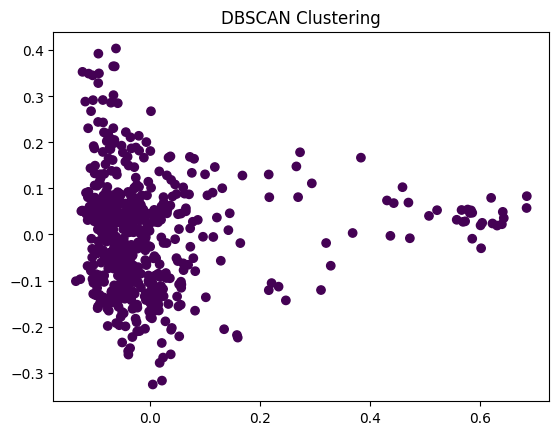

In [153]:
## Plotting:
plt.scatter(reduced_features[:,0], reduced_features[:, 2], c=clusters)
plt.title("DBSCAN Clustering")
plt.show()